# Open and run analysis on multiple polygons <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Many users need to run analyses on their own areas of interest. 
A common use case involves running the same analysis across multiple polygons in a vector file (e.g. ESRI Shapefile or GeoJSON). 
This notebook will demonstrate how to use a vector file and the Open Data Cube to extract satellite data from Digital Earth Australia corresponding to individual polygon geometries.

## Description
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

We can retrieve data for each polygon, perform an analysis like calculating NDVI and plot the data.

1. First we open the vector file as a `geopandas.GeoDataFrame`
2. Iterate through each polygon in the `GeoDataFrame`, and extract satellite data from DEA
3. Calculate NDVI as an example analysis on one of the extracted satellite timeseries
4. Plot NDVI for the polygon extent

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand.

In [1]:
%matplotlib inline

import sys

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.crs
import rioxarray
from datacube.utils import geometry

sys.path.append("../Scripts")
import functools
import os
import pickle

import datacube.utils.cog

# import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import matplotlib.cm
import matplotlib.colors

# import matplotlib.pyplot as plt
import numpy as np
import odc.ui
import rasterio.features
import rioxarray
import skimage.color as colour
import skimage.io
import sklearn.metrics
import xarray as xr

# import sys
# import datacube
from datacube.storage.masking import make_mask

# from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_coastaltools import tidal_stats, tidal_tag
from dea_dask import create_local_dask_cluster
from dea_datahandling import array_to_geotiff, load_ard
from dea_plotting import display_map, map_shapefile, rgb
from dea_spatialtools import xr_rasterize
from dea_temporaltools import time_buffer
from IPython.display import display
from odc.ui import with_ui_cbk
from shapely.geometry import shape, Polygon
from tqdm.notebook import tqdm

# %matplotlib widget

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

import matplotlib.gridspec as gridspec

import matplotlib as mpl

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data.

In [2]:
dc = datacube.Datacube(app="Analyse_multiple_polygons")
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33811 Dashboard: /user/cp/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


# *Load predetermined polygons and select a region of interest*

In [3]:
## User defines path to polygon vector file, file name and 
## the column name for unique integer identifiers for each vector object.
%cd '/home/jovyan/dev/dea-notebooks/Claire/'
vector_file = "QISMCQ_polygons.shp"
attribute_col = "id"

/home/jovyan/dev/dea-notebooks/Claire


In [4]:
# Read in the polygon vector file
gdf_master = gpd.read_file(vector_file)

# Set the crs to match the imagery data retrieved
gdf_master.to_crs(epsg=3577, inplace=True)

# #  View the unique classes
# print(gdf_master["BRD_HAB"].unique())

#  Drop unrequired classes
gdf_master = gdf_master.drop(
    gdf_master[
        (gdf_master.BRD_HAB == 'Subtidal consolidated substrate')
        | (gdf_master.BRD_HAB == 'Intertidal consolidated substrate')
        | (gdf_master.BRD_HAB == 'Intertidal coral')
        | (gdf_master.BRD_HAB == 'Subtidal coral')
        | (gdf_master.BRD_HAB == 'Subtidal unconsolidated substrate')
        | (gdf_master.BRD_HAB == "Intertidal unconsolidated substrate")
        | (gdf_master.BRD_HAB == 'Intertidal algae')
        | (gdf_master.BRD_HAB == 'Subtidal seagrass')
        | (gdf_master.BRD_HAB == 'Subtidal algae')
    ].index
)

#  Reset the index of the gdf to infill dropped values
gdf_master.reset_index(inplace=True)

#  Check that correct classes remain
print(gdf_master["BRD_HAB"].unique())

# Attribute each class with an integer value
val = (gdf_master["BRD_HAB"].unique()).tolist()

num_list = []
attr_key = []

d = 0
for x in range(len(gdf_master)):
    for d in range(len(val)):
        if gdf_master["BRD_HAB"].values[x] == str(val[d]):
            num_list.append(d)
        # Create a key to interpret the integer attribute for each class
        for y in num_list:
            if y not in attr_key:
                attr_key.append(y)

val = [[el] for el in val]
for x in attr_key:
    val[x].append(attr_key[x])


print("The attribute values for each class are as follows: " + str(val))

# Update the geodataframe of vector polygons with the integer attribution for each class
gdf_master["id"] = num_list

# Map the shapefiles from imported vector set
roi = map_shapefile(gdf_master, attribute=attribute_col)

['Intertidal mangroves and other trees & shrubs'
 'Intertidal grass-herb-sedge-other succulent' 'Intertidal seagrass']
The attribute values for each class are as follows: [['Intertidal mangroves and other trees & shrubs', 0], ['Intertidal grass-herb-sedge-other succulent', 1], ['Intertidal seagrass', 2]]


Map(center=[-23.952787292499956, 151.32995860600005], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [15]:
## Give a name to your roi for file saving
name = 'multi_sensor_test'

This selection includes  1  individual polygons


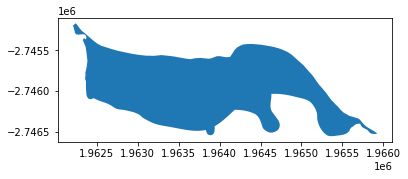

In [18]:
'''
After identifying an analysis region of interest(roi) on the map,
intersect the roi with the master polygon gdf from which imagery 
will be extracted. Note that when multiple areas are drawn on the
map above, it is the final roi that is used for analysis in the 
following cells
'''

##  Form a shapely polygon from the coordinates defined by the user on the map
polygon_roi = Polygon(roi[-1]['geometry']['coordinates'][0])

##  Generate a new geodataframe containing the user defined polygon geometry
newdf = gpd.GeoDataFrame(gpd.GeoSeries(polygon_roi), columns=['geometry'], crs='EPSG:4326')
newdf = newdf.to_crs(gdf_master.crs)

##  Intersect the user-defined region of interest with the master
##  to create the working gdf from which imagery will be extracted
gdf = gpd.overlay(gdf_master, newdf, how='intersection')
print('This selection includes ', len(gdf), ' individual polygons')
gdf.plot()


In [42]:
# ## Test cell

# # Set some configurations for displaying tables nicely
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.max_rows', None)

# products = dc.list_products()

# display_columns = ["name",
#                    "description",
#                    "platform",
#                    "instrument",
#                    "crs",
#                    "resolution"]

# products[display_columns].sort_index()

# Load imagery for the region of interest

*user to define time-period of interest in the query*

In [43]:
# Setup the general query and variables for later
products = ["ga_ls5t_ard_3",
            "ga_ls7e_ard_3",
            "ga_ls8c_ard_3",
            'nidem',
            'item_v2',
            'item_v2_conf']
align = (0, 0)

# Query
query = {
    "time": ("1986-01-01", "2021-01-01"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
    "output_crs": "EPSG:3577", # Do not change th
    "resolution": (-30, 30),
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
}

# Designate dask chunks
# It doesn't really matter how big the chunks we load are, as long as time ~ 1.
chunks = {"time": 1, "x": 3000, "y": 3000}

# Load data for predetermined polygons
# Dictionary to save results
results = {}

'''List of saved tideposts. In the event that a polygon centroid geometry fails
to return an associated tideheight, the tidal_tag function will bring in this list
and use the most recent successful polygon centroid geometry to calculate a tideheight
for the current polygon'''
tideposts = [[0,0]]

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f"Feature: {index + 1}/{len(gdf)}")
    print(gdf["BRD_HAB"].values[index])
    print(str(index))
    print(str(row))

    if not (str(row[attribute_col]) in results.keys()):
        results[str(row[attribute_col])] = {}

    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({"geopolygon": geom})

    # Load landsat
    ds = load_ard(
        dc=dc,
        products=products,
        min_gooddata=0.90,  # only take uncloudy scenes
        ls7_slc_off=False,
        skip_broken_datasets=True, ## New line 25/02/2021 TEMP fix while lingering ARD issue sorted
        **query,
    )

    ## Tidally tag datasets
    ds, tidepost_lon, tidepost_lat = tidal_tag(ds,
                                               tideposts[-1],
                                               return_tideposts=True,
                                               ebb_flow=True)
    tideposts.append([tidepost_lon, tidepost_lat])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    ## Attach unique polygon id to each dataset
    attrs = {'pgid': row['OBJECTID']}
    ds.attrs = attrs

    # Append results to a dictionary using the attribute
    # column as an key
    results[str(row[attribute_col])][str(index)] = ds

    print(row[attribute_col], index)
    print("----------------------")

Feature: 1/1
Intertidal seagrass
0
index                                                                                                                                                                                                            3551
OBJECTID                                                                                                                                                                                                         3552
CONSOL                                                                                                                                                                                                              U
DOM_TYPE                                                                                                                                                                                                           12
DOM_LABEL                                                                                                    

../Scripts/dea_datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    nidem
    item_v2
    item_v2_conf
Counting good quality pixels for each time step
Filtering to 337 out of 1009 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 337 time steps as a dask array
Setting tide modelling location from dataset centroid: 151.59, -24.04
Modelling tidal phase (e.g. ebb or flow)
Rasterizing to match xarray.DataArray dimensions (47, 125)
2 0
----------------------


## Filter results by tide height, calculate indices and build ITEM masks

*user to define tide_range to keep - set the desired quantile value in `lowest_20` variable*

*user defines required indices in the `calculate_indices` function call*

In [44]:
results2 = {}
x=1

for k in results:

    if not (str(k) in results2.keys()):
        results2[str(k)] = {}
        
    for kk in results[k]:
        
        ds = results[k][kk] 
        
        ## Save attributes to reattach later
        attrs = ds.attrs
        
        ## Filter data by tide height
        lowest_10 = ds.tide_height.quantile([0.10]).values
        lowest_20 = ds.tide_height.quantile([0.20]).values  
        results2[k][kk] = ds.where(ds.tide_height <= lowest_20, drop=True)      
        
        ## Compute data from dask - WARNING: time consuming step!
        results2[k][kk] = results2[k][kk].compute()       
        ds = results2[k][kk]
       
        ## Drop tide_height and ebb_flow variables
        '''
        works around the calculate_indices function which was stalling on the additional 
        coastal variables, drop tide_height and ebb_flow variables
        '''
        tide_height = ds['tide_height']
        ebb_flow = ds['ebb_flow']
        ds = ds.drop_vars(names = ('tide_height', 'ebb_flow'))
        
        # calculate ndvi for pixels inside the polygon
        ds = calculate_indices(ds, index=['NDVI', 'MNDWI', 'NDAVI', 'WAVI', 'EVI', 'SAVI', 'NDWI'], 
                               collection='ga_ls_3', inplace=True)
        
        # Add tide_height back in to calculate ITEM mask
        ds['tide_height'] = tide_height

        ## Prepare data to calculate ITEM masks
        lowest_10 = ds.where(ds.tide_height <= lowest_10, drop=True)
        lowest_20 = ds.where(ds.tide_height <= lowest_20, drop=True)

        ## Calculate ITEM layers
        lowest_10_mask = lowest_10[['NDWI', 'tide_height']].median(dim='time')
        lowest_20_mask = lowest_20[['NDWI', 'tide_height']].median(dim='time')
        
#         # Add ITEM mask layers to results2 datasets
        results2[k][kk]['lowest_10_mask'] = lowest_10_mask.NDWI <= 0 
        results2[k][kk]['lowest_20_mask'] = lowest_20_mask.NDWI <= 0 
        
        results2[str(k)][str(kk)] = xr.merge([results2[str(k)][str(kk)], ds])
        
        ## Attach unique polygon id to each dataset
        results2[str(k)][str(kk)].attrs = attrs
        
        ## Update progress
        ## New line. If cell fails, explore here first. 
        ## Probably an issue with the call to `index` from cell above
        print(f"Completed feature: {x}/{index + 1}") 
        
        x=x+1

Completed feature: 1/1


# Save loaded results
*By default, save the imagery and polygon sub-sampled datasets every time.*

*If required to load last dataset, hash out the `save` calls and unhash the `load` calls*

In [45]:
## Save variables

## Save imagery dict
with open('results2_' + query['time'][0] + name +'.pickle', 'wb') as handle:
    pickle.dump(results2, handle)
 
## Save polygon gdf   
with open('gdf_' + query['time'][0] + name +'.pickle', 'wb') as handle:
    pickle.dump(gdf, handle)
    
'''-----------------------------------------'''

# # Load saved variables (hashed out by default)

# ## Load the name for your roi
# name = 'Rodds_Bay'

# ## Re-load the query

# # Setup the general query and variables for later
# products = ["ga_ls8c_ard_3"]
# align = (0, 0)

# # Query
# query = {
#     "time": ("2013-01-01", "2020-08-01"),
#     "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
#     "output_crs": "EPSG:3577", # Do not change th
#     "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
# }

# ## ensure that you are working from the same directory as the files are stored
# %cd '/home/jovyan/dev/dea-notebooks/Claire'

# ## Load imagery dict
# with open('results2_' + query['time'][0]+ name +'.pickle', 'rb') as handle:
#     results2 = pickle.load(handle)

# ## Load polygon gdf    
# with open('gdf_' + query['time'][0]+ name +'.pickle', 'rb') as handle:
#     gdf = pickle.load(handle)




'-----------------------------------------'

In [55]:
## Test cell

results2['2']['0'] ## Doesn't look to have loaded ITEM or NIDEM

<xarray.Dataset>
Dimensions:         (time: 68, x: 124, y: 46)
Coordinates:
  * time            (time) datetime64[ns] 1988-05-22T23:24:07.327213 ... 2020...
  * y               (y) float64 -2.745e+06 -2.745e+06 ... -2.747e+06 -2.747e+06
  * x               (x) float64 1.962e+06 1.962e+06 ... 1.966e+06 1.966e+06
    spatial_ref     int32 3577
Data variables:
    nbart_red       (time, y, x) float32 273.0 275.0 nan nan ... nan nan nan nan
    nbart_green     (time, y, x) float32 506.0 509.0 nan nan ... nan nan nan nan
    nbart_blue      (time, y, x) float32 412.0 387.0 nan nan ... nan nan nan nan
    nbart_nir       (time, y, x) float32 143.0 144.0 nan nan ... nan nan nan nan
    nbart_swir_1    (time, y, x) float32 69.0 69.0 nan nan ... nan nan nan nan
    tide_height     (time, y, x) float64 -0.679 -0.679 nan nan ... nan nan nan
    ebb_flow        (time, y, x) object 'Flow' 'Flow' nan nan ... nan nan nan
    lowest_10_mask  (y, x) bool False False False False ... False False False
    lowest_20_mask  (y, x) bool False False False False ... False False False
    NDVI            (time, y, x) float32 -0.3125 -0.31264916 nan ... nan nan nan
    MNDWI           (time, y, x) float32 0.75999993 0.76124567 nan ... nan nan
    NDAVI           (time, y, x) float32 -0.4846847 -0.45762715 nan ... nan nan
    WAVI            (time, y, x) float32 -0.07263726 -0.06590128 nan ... nan nan
    EVI             (time, y, x) float32 -0.037395008 -0.03683293 ... nan nan
    SAVI            (time, y, x) float32 -0.03600443 -0.036261305 ... nan nan
    NDWI            (time, y, x) float32 0.55932206 0.55895865 nan ... nan nan
Attributes:
    pgid:     3552.0

# Data Analysis

Load the following cell to define the functions that enable data interrogation and visualisation

In [27]:
### funcs for py script

## Testing updated coastal_wit func. Drafted in BKUP notebook and copied over to this cell

def coastal_wit(
               results2,
               pg,
               ITEM_mask = 'lowest_20_mask',
               classes = False
                    ):
    """
    Takes a polygon or polygons in a region of interest ([pg]) from the gdf of polygon shapefiles and extracts 
    and plots the frequency of pixels as assigned into class ranges of NDVI. Also includes pixels identified
    as wet. All NDVI pixels are masked by 'dry' range of NDWI and everything is masked by the ITEM mask.
    If conditional dataset dropping is required, set drop=True and nominate the percent of wet pixels
    tolerated and the minimum number of allowable pixels (e.g. pc_drop=90 means drop any timestep dataset
    when more than 90% of pixels are wet; px_min=5 means that a timestep dataset will only be dropped
    when more than pc_drop pixels are wet AND the remaining pixels sum to less than or = px_min - or
    5 in this case)
    If the WIT datasets have already been generated and included in the xarray dataset (`results2`) then 
    set `classes = True` to avoid re-calculation. Default is False.
    ITEM_mask is the layer to nominate for ITEM masking. If no masking required, select one of the 
    original bands such as 'nbart_red'
    """
    

    ## Set up lists to extract pixel counts per timestep into
    ls_pixels = []
    ls_ndwi = []
    ls_unveg = []
    ls_ndvilow = []
    ls_ndvimid = []
    ls_ndvihigh = []
    ls_pxsum = []
    ls_tide = []
    ls_index = []

    ##  Data prep for WIT prototype (automated for all timesteps for all polygons)

    ##  Generate all datasets for the stacked line plot (WIT) by adding as variables to results dataset
    for k in results2:
        for kk in results2[k]: 

            if classes == False:

                ##  Add a non-water pixel mask variable
                results2[k][kk]['mask'] = ((results2[k][kk].NDWI)
                                           .where(results2[k][kk][ITEM_mask]) <= 0)

                ##  Generate the NDWI_water class
                results2[k][kk]['ndwi_water'] = ((results2[k][kk].NDWI)
                                                  .where(results2[k][kk][ITEM_mask]) > 0)

                ##  Generate NDVI classes

                ##  NDVI less than 0.1
                results2[k][kk]['unveg'] = (results2[k][kk].NDVI
                                            .where((results2[k][kk].NDVI < 0.1).astype(int))
                                            .where(results2[k][kk][ITEM_mask]))

                ##  NDVI 0.1 to 0.33
                results2[k][kk]['ndvi_low'] = (results2[k][kk].NDVI
                                               .where((results2[k][kk].NDVI >= 0.1).astype(int) & 
                                                      (results2[k][kk].NDVI < 0.333).astype(int))
                                               .where(results2[k][kk][ITEM_mask]))

                ##  NDVI 0.33 to 0.66
                results2[k][kk]['ndvi_mid'] = (results2[k][kk].NDVI
                                               .where((results2[k][kk].NDVI >= 0.333).astype(int) & 
                                                      (results2[k][kk].NDVI < 0.666).astype(int))
                                               .where(results2[k][kk][ITEM_mask]))

                ### NDVI 0.66 to 1
                results2[k][kk]['ndvi_high'] = (results2[k][kk].NDVI
                                                .where((results2[k][kk].NDVI >= 0.666).astype(int) & 
                                                       (results2[k][kk].NDVI <= 1).astype(int))
                                                .where(results2[k][kk][ITEM_mask]))

                ##  Mask the NDVI classes to show non-water pixels only
                results2[k][kk]['unveg'] = results2[k][kk]['unveg'].where(results2[k][kk]['mask'])
                results2[k][kk]['ndvi_low'] = results2[k][kk]['ndvi_low'].where(results2[k][kk]['mask'])
                results2[k][kk]['ndvi_mid'] = results2[k][kk]['ndvi_mid'].where(results2[k][kk]['mask'])
                results2[k][kk]['ndvi_high'] = results2[k][kk]['ndvi_high'].where(results2[k][kk]['mask'])

                for x in pg:
                    if x == results2[str(k)][str(kk)].attrs['pgid']:
                         ##  Populate pixel count lists per class per timestep
                        for t in range (0, len(results2[str(k)][str(kk)].time)):
                            ls_pixels.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].where(results2[k][kk][ITEM_mask]).isel(time=t).nbart_red)))
                            ls_ndwi.append(np.count_nonzero(results2[str(k)][str(kk)].isel(time=t).ndwi_water))
                            ls_unveg.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).unveg)))
                            ls_ndvilow.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_low)))
                            ls_ndvimid.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_mid)))
                            ls_ndvihigh.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_high)))
                            ls_pxsum.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].where(results2[k][kk][ITEM_mask]).isel(time=t).nbart_red)))
                            ls_tide.append(results2[str(k)][str(kk)].isel(time=t).tide_height.median().values)

                        ls_index.append(results2[str(k)][str(kk)].time.values)
    ls_index = np.concatenate(ls_index).tolist()
#                                 index = results2[str(k)][str(kk)].time.values

#         if classes == True:

#              ##  Populate pixel count lists per class per timestep
#             for t in range (0, len(results2.time)):
#                 ls_pixels.append(np.count_nonzero(~np.isnan(results2.isel(time=t).nbart_red)))
# #                 ls_mndwi.append(np.count_nonzero((results2.isel(time=t).mndwi_water)))
#                 ls_mndwi.append(np.count_nonzero(~np.isnan(mWIT1.isel(time=t).mndwi_water.where(mWIT1.isel(time=t).mndwi_water == True))))
#                 ls_unveg.append(np.count_nonzero(~np.isnan(results2.isel(time=t).unveg)))
#                 ls_ndvilow.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_low)))
#                 ls_ndvimid.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_mid)))
#                 ls_ndvihigh.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_high)))
#                 ls_pxsum.append(np.count_nonzero(~np.isnan(results2.isel(time=t).nbart_red)))
#                 ls_tide.append(results2.isel(time=t).tide_height.median().values)

#                 index = results2.time.values


    ## Return index values to datetime64
    for x in range(0, len(ls_index)):
        ls_index[x] = np.datetime64(int(ls_index[x]), 'ns')

    ##  Generate a dataframe summarising class pixel counts per timestep
    classes_df = pd.DataFrame(
                {"pixels": ls_pixels,
                "water": ls_ndwi,
                "unveg": ls_unveg,
                "ndvi_low": ls_ndvilow,
                "ndvi_mid": ls_ndvimid,
                "ndvi_high": ls_ndvihigh,
                "px_sum": ls_pxsum,
                "tide_height": ls_tide},
                index = ls_index
                )

    ## Aggregate the datasets to account for identical imagery dates spanning different polygons
    ## All pixel values are summed. Tide_height values are averaged
    ## Separate tide_height dataset and convert to dataframe
    classes_df_th = classes_df.tide_height
    classes_df_th = pd.DataFrame(classes_df_th)

    ## Drop tide_height from main df then group rows with duplicate indices and then sum them up
    classes_df = classes_df.drop(['tide_height'], axis=1)
    classes_df = classes_df.groupby(classes_df.index).sum()

    ## Take tide-height values and convert from array to int
    intlist=[]
    for x in range (0,len(classes_df_th.tide_height.values.tolist())):
        intlist.append(classes_df_th.tide_height.values.tolist()[x].tolist())

    ## Add integer list to tide_height dataframe and drop array list
    classes_df_th['th_int'] = intlist
    classes_df_th = classes_df_th.drop('tide_height', axis=1)

    ## Group by index dates as per classes_df and calculate mean tide_height value
    classes_df_th = classes_df_th.groupby(classes_df_th.index).mean()

    ## Merge the pixel and tide_height datasets back together
    classes_df = classes_df.merge(classes_df_th, left_on = classes_df.index, right_on = classes_df_th.index)

    ## Rename tide_height column to something sensible
    classes_df = classes_df.rename(columns={'th_int':'tide_height'})

    ## Reset the index to observation dates
    classes_df.set_index('key_0', inplace=True)

    ##  Normalise pixel counts per class per timestep
    classes_df['pc_water'] = classes_df['water']/classes_df['pixels']*100
    classes_df['pc_unveg'] = classes_df['unveg']/classes_df['pixels']*100
    classes_df['pc_ndvi_low'] = classes_df['ndvi_low']/classes_df['pixels']*100
    classes_df['pc_ndvi_mid'] = classes_df['ndvi_mid']/classes_df['pixels']*100
    classes_df['pc_ndvi_high'] = classes_df['ndvi_high']/classes_df['pixels']*100
    classes_df['pc_total'] = (classes_df['pc_water']+
                              classes_df['pc_unveg']+
                              classes_df['pc_ndvi_low']+
                              classes_df['pc_ndvi_mid']+
                              classes_df['pc_ndvi_high'])
    classes_df['pc_exposedpx'] = (classes_df['unveg']+
                                  classes_df['ndvi_low']+
                                  classes_df['ndvi_mid']+
                                  classes_df['ndvi_high'])/classes_df['px_sum']*100


    return classes_df, results2

def onclick_timeseries(event):
    '''
    This widget allows the user to select a time point from a plotted time series. 
    It then translates the chosen point back into the approriate datetime object so
    that it can be used to find the location of this time point within the extracted
    datasets. The index location of this time step is also returned. 
    
    '''
    global time_slice, TimeIndex, pixelx, pixely
    
    # Get time from x axis of plot 
    timeOfInterest = event.xdata
    
    # Get x and y coordinates from click
    pixelx, pixely = int(event.xdata), int(event.ydata)
    
    # Add point to image
    plt.plot(pixelx, pixely, 'ro', markersize=5)
    
    # Convert clicked int to datetime format
    time_slice = matplotlib.dates.num2date(timeOfInterest).date()
    
    # Convert clicked value to str
    time_slice = str(time_slice)
    
    # Convert clicked value to correct datetime format
    time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
    
    # Find the time index of the chosen time slice
    TimeIndex = results2[str(cl)][str(pg1)].indexes['time'].get_loc(time_slice, method='nearest')
    
    # Print the date of the image closest to clicked pixel
    ClosestImage = results2[str(cl)][str(pg1)].time[TimeIndex].values
    
    # Update text below plot
    w2.value = 'Closest imagery date : {}'.format(ClosestImage)
    
        
def temporal_stats (gdf, 
                    results2,
                    zonal=True,
                    pixel=True,
                    mask= 'lowest_20_mask'):

    '''
    This function calculates and returns the temporal mean and standard deviation
    for a range of indices for every polygon and every pixel within
    every polygon in the form of a geodataframe.  
    For now, leave zonal and pixel set to True to calculate all results. Func may
    not work if either of these vars are set to False.
    ITEM masking is available using the `mask` variable. If no masking is required, set
    this variable to one of the bands such as 'nbart_nir'. If masking, two ITEM
    layers are generated by default to choose from. Either 'lowest_20_mask' for
    all images except those associated with the lowest 20% of observed tides, or
    'lowest_10_mask' to mask by the equivalent in the 10% range.
    '''
    ##  Spectral indices available in the `calculate_indices` function (dea_bandindices.py)
    index_ls = [
        "NDVI",
        "EVI",
        "NDAVI", 
        "WAVI",
        "LAI",
        "SAVI",
        "MSAVI",
        "NDMI",
        "NBR",
        "BAI",
        "NDCI",
        "NDSI",
        "NDTI",
        "NDWI",
        "MNDWI",
        "NDBI",
        "BUI",
        "BAEI",
        "NBI",
        "BSI",
        "AWEI_ns",
        "AWEI_sh",
        "WI",
        "TCW",
        "TCG",
        "TCB",
        "CMR",
        "FMR",
        "IOR",
    ]

       
    
    ## Calculate zonal polygon results
    if zonal:
        
        gdf_zonal = gdf 
        
        ##  Generate a list of keys for polygons in class '0' of results2
        keylist = list(results2['2'].keys())

        ##  For each nominated indice:
        for var in index_ls:
            if var in results2["2"][keylist[0]].var():

                lsmean = []
                lsstd = []

                ##  Generate zonal indice stats for polygon followed by temporal statistic
                ##  Append polygon id and temporal statistic to gdf
                for k in results2:

                    for kk in results2[k]:
                        temporalmean = ((results2[k][kk][var]
                                         .where(results2[k][kk][mask])
                                         .mean('y')
                                         .mean('x'))
                                         .mean())
                        lsmean.append([int(kk), temporalmean.values])
                        name1 = str(var) + ' zonal mean'
                        results2[str(k)][str(kk)][name1] = (temporalmean.values)
                        
                        temporalstd = ((results2[k][kk][var]
                                        .where(results2[k][kk][mask])
                                        .std('y')
                                        .std('x'))
                                        .std())
                        lsstd.append([int(kk), temporalstd.values])  
                        name2 = str(var) + ' zonal std'
                        results2[str(k)][str(kk)][name2] = (temporalstd.values)                        

                ##  Sort the list by polygon id to match up to the original polygon gdf
                lsmean = sorted(lsmean)
                lsstd = sorted(lsstd)

                ##  Separate the sorted polygon ids from the indice statistic to build into a pd.DataFrame
                indicemean = []
                indicestd = []
                polyid = []

                for x in lsmean:
                    polyid.append(x[0])
                    indicemean.append(x[1])

                for x in lsstd:
                    indicestd.append(x[1])

                # Build a pd.DataFrame from the sorted polygon id and indice statistics. 
                # Nominate a name for the new column.
                indexstats = pd.DataFrame(
                    indicemean, index=polyid, columns=[str(var) + " zonal mean"]
                )

#                 indexstats[str(var) + ' zonal mean'] = indicemean
#                 indexstats['polyid'] = polyid 
    
                indexstats[str(var) + " zonal std"] = None
                indexstats.loc[polyid, (str(var) + " zonal std")] = indicestd

                # Workaround to handle automatic addition of key_0 column at merge step
                if "key_0" in gdf_zonal.columns:
                    gdf_zonal.drop(columns=["key_0"], inplace=True)

                # # Merge the indice statistic for each polygon into the original polygon gdf
                gdf_zonal = gdf_zonal.merge(indexstats, on=indexstats.index)

        ## Rename the 'index' column to avoid confusion with the gdf.index
        gdf_zonal.rename(columns={'OBJECTID' : 'pgid'}, inplace=True)
        gdf_zonal.rename(columns={'geometry' : 'pg_geometry'}, inplace=True)

#                         return gdf

    ## Calculate pixel results
    if pixel:

        ## New dict to store arrays
#         pxsummary = {}

        ## Master gdf
        gdf_px = gpd.GeoDataFrame()
        gdf_px['geometry'] = None

        ## List to store geom, unique pixel id 
        # pxid = []
        uniquepx = []
        pxgeom = []

        ##  Generate a list of keys for polygons in class '0' of results2
        keylist = list(results2['2'].keys())


        ##  Generate zonal indice stats for polygon followed by temporal statistic
        ##  Append polygon id and temporal statistic to gdf
        for k in results2:

#             if not (str(k) in pxsummary.keys()):
#                 pxsummary[str(k)] = {}

            for kk in results2[k]:

                lon = []
                for value in results2[k][kk].x.values:
                    lon.append(value)

                lat = []
                for value in results2[k][kk].y.values:
                    lat.append(value)

                ds = xr.Dataset()

                ##  For each nominated indice:
                for var in index_ls:
                    if var in results2["2"][keylist[0]].var():

                        temporalmean = (results2[str(k)][str(kk)][var]
                                        .where(results2[k][kk][mask])
                                        .mean(dim='time'))
                        name1 = str(var) + ' px mean'
                        ds[name1] = (('y', 'x'), temporalmean)
                        results2[str(k)][str(kk)][name1] = (('y', 'x'), temporalmean)

                        temporalstd = (results2[k][kk][var]
                                       .where(results2[k][kk][mask])
                                       .std(dim='time'))
                        name2 = str(var) + ' px std'
                        ds[name2] = (('y', 'x'), temporalstd)
                        results2[str(k)][str(kk)][name2] = (('y', 'x'), temporalstd)

                ds.coords['lon'] = ('x'), lon
                ds.coords['lat'] = ('y'), lat


                ## Extract pixel geometry/shape for input into gdf for choropleth plotting
                # Extract dataset matching polygon
                closest_ds = results2[k][kk]

                ## Extract pgid attributes to attach later
                attrs = closest_ds.attrs
                ds.attrs = attrs

                ## Skip empty arrays
                if closest_ds.x.size == 0:
                    print('Empty arrays: k: ', k, 'kk: ', kk)
                    continue
                else:       
                    # Input array (based on red band) to segment and vectorise
                    input_array = closest_ds.nbart_red
                    input_transform = closest_ds.affine  
                    input_crs = input_array.crs

                    # Create array with a unique value per cell
                    unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

                    # Vectorise each unique feature in array
                    vectors = rasterio.features.shapes(
                        source=unique_pixels.astype(np.int16), transform=input_transform
                    )

                    # Extract polygons and values from generator
                    vectors = list(vectors)
                    values = [value for polygon, value in vectors]
                    polygons = [shape(polygon) for polygon, value in vectors]
                    pp = np.array(polygons)
                    pp = pp.reshape(len(input_array.y), len(input_array.x))

#              # Create a geopandas dataframe populated with the polygon shapes
#              closestdate_poly_gdf = gpd.GeoDataFrame(data={"id": values}, geometry=polygons, crs=input_crs)

                    ds['geometry'] = (('y', 'x'), pp)

                results2[k][kk]['geometry'] = (('y', 'x'), pp)
                results2[k][kk].set_coords('geometry')


                ## Append [geom, unique pixel id] to list for later addition to gdf, merging on geom
                pxid2 = []
                pgid2 = []

                for x in ds['x']:
                    for y in ds['y']:
                        pxid1 = str(attrs['pgid'])+'_'+str(ds['y'][y].item())+'_'+str(ds['x'][x].item())
                        gm = pp[ds['y'][y].item()][ds['x'][x].item()]

                        uniquepx.append(pxid1)
                        pxgeom.append(gm)
                        pxid2.append(pxid1)
                        pgid2.append(attrs['pgid'])

                pxid2 = np.array(pxid2).reshape(ds.y.shape[0], ds.x.shape[0])
                pgid2 = np.array(pgid2).reshape(ds.y.shape[0], ds.x.shape[0])
                results2[k][kk]['pxid'] = (('y', 'x'), pxid2)

                ds['pgid'] = (('y', 'x'), pgid2)

                ## Reattach attrs
                results2[k][kk].attrs = attrs

#                 pxsummary[k][kk] = ds

                ## Append ds to gdf_px
                ds = ds.to_dataframe()
                gdf_px = gdf_px.append(ds)
                gdf_px.crs = gdf.crs

        pxid = gpd.GeoDataFrame(uniquepx, geometry=pxgeom, columns=['pxid'], crs=input_crs)

        gdf_px.reset_index(inplace=True)

        gdf_px = gdf_px.merge(pxid)
        gdf_px.set_index('pxid', inplace=True, drop=False)
        gdf_px.dropna(axis=0, inplace=True)
        gdf_px.sort_index(level='pxid', inplace=True)

    if zonal == True & pixel == True:
        ## Merge the (zonal) gdf and gdf_px
        gdf_merged = gdf_px.merge(gdf_zonal, on = 'pgid')

        ## Drop the pg_geometry to use the pixel geometry default
        gdf_merged.drop(columns='pg_geometry', inplace=True)

        ##  Create new gdf's for each class to plot
        grasses = gdf_merged.drop(
            gdf_merged[gdf_merged.BRD_HAB != "Intertidal grass-herb-sedge-other succulent"].index
        )
        mangroves = gdf_merged.drop(
            gdf_merged[gdf_merged.BRD_HAB != "Intertidal mangroves and other trees & shrubs"].index
        )
        seagrass = gdf_merged.drop(gdf_merged[gdf_merged.BRD_HAB != "Intertidal seagrass"].index)

        ##  Drop polygons containing NaN values
        ##  ASSUMPTION: if NDVI contains NaNs, all indices will contain NaNs. 
        ##  ToDo: write a loop or func that looks for NaNs in any of the supplied indices
        grasses = grasses.dropna(axis=0, how='any', subset=[
                                                   'NDVI zonal mean', 
                                                   'NDVI px mean', 
                                                   'NDVI zonal std', 
                                                   'NDVI px std'])
        mangroves = mangroves.dropna(axis=0, how='any', subset=[
                                                   'NDVI zonal mean', 
                                                   'NDVI px mean', 
                                                   'NDVI zonal std', 
                                                   'NDVI px std'])
        seagrass = seagrass.dropna(axis=0, how='any', subset=[
                                                   'NDVI zonal mean', 
                                                   'NDVI px mean', 
                                                   'NDVI zonal std', 
                                                   'NDVI px std']) 
    if zonal == False:
        
         ## Merge the (zonal) gdf and gdf_px
        gdf_merged = gdf_px.merge(gdf, on = 'pgid')

        ## Drop the pg_geometry to use the pixel geometry default
        gdf_merged.drop(columns='pg_geometry', inplace=True)        

        ##  Create new gdf's for each class to plot
        grasses = gdf_merged.drop(
            gdf_merged[gdf_merged.BRD_HAB != "Intertidal grass-herb-sedge-other succulent"].index
        )
        mangroves = gdf_merged.drop(
            gdf_merged[gdf_merged.BRD_HAB != "Intertidal mangroves and other trees & shrubs"].index
        )
        seagrass = gdf_merged.drop(gdf_merged[gdf_merged.BRD_HAB != "Intertidal seagrass"].index)

        ##  Drop polygons containing NaN values
        ##  ASSUMPTION: if NDVI contains NaNs, all indices will contain NaNs. 
        ##  ToDo: write a loop or func that looks for NaNs in any of the supplied indices
        grasses = grasses.dropna(axis=0, how='any', subset=[
#                                                    'NDVI zonal mean', 
                                                   'NDVI px mean', 
#                                                    'NDVI zonal std', 
                                                   'NDVI px std'])
        mangroves = mangroves.dropna(axis=0, how='any', subset=[
#                                                    'NDVI zonal mean', 
                                                   'NDVI px mean', 
#                                                    'NDVI zonal std', 
                                                   'NDVI px std'])
        seagrass = seagrass.dropna(axis=0, how='any', subset=[
#                                                    'NDVI zonal mean', 
                                                   'NDVI px mean', 
#                                                    'NDVI zonal std', 
                                                   'NDVI px std']) 

    return gdf_merged, results2, grasses, mangroves, seagrass

In [17]:
## Temp - data loading cell

# # ## Delete all variables, leaving imported modules # https://stackoverflow.com/questions/26545051/is-there-a-way-to-delete-created-variables-functions-etc-from-the-memory-of-th
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]
# # OR
# # reset # as per https://stackoverflow.com/questions/26545051/is-there-a-way-to-delete-created-variables-functions-etc-from-the-memory-of-th

# # Load saved variables (hashed out by default)

## Load the name for your roi
name = 'Gladstone_Harbour_upperreach'

## Re-load the query

# Setup the general query and variables for later
products = ["ga_ls8c_ard_3"]
align = (0, 0)

# Query
query = {
    "time": ("2013-01-01", "2020-08-01"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
    "output_crs": "EPSG:3577", # Do not change th
    "resolution": (-30, 30),
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
}

## ensure that you are working from the same directory as the files are stored
%cd '/home/jovyan/dev/dea-notebooks/Claire'

## Load imagery dict
with open('results2_' + query['time'][0]+ name +'.pickle', 'rb') as handle:
    results2 = pickle.load(handle)

## Load polygon gdf    
with open('gdf_' + query['time'][0]+ name +'.pickle', 'rb') as handle:
    gdf = pickle.load(handle)


/home/jovyan/dev/dea-notebooks/Claire


In [18]:
name

'Gladstone_Harbour_upperreach'

## Generate zonal and temporal stats for each polygon

In [28]:
## Generate zonal and pixel stats and attach to class polygons
gdf_merged, results2, grasses, mangroves, seagrass = temporal_stats(gdf, 
                                                                    results2, 
                                                                    mask='lowest_20_mask')

#### View the zonal statistics temporal summaries

In [ ]:
##  Plot grasses
# print('Select attribute from: ', gdf_merged.columns)

roi = map_shapefile(grasses, attribute="NDVI px std", continuous=True)

In [ ]:
##  Plot mangroves
roi = map_shapefile(mangroves, attribute="NDVI px std", continuous=True)

In [29]:
##  Plot seagrass
roi = map_shapefile(seagrass, attribute="NDVI px std", continuous=True)

Map(center=[-24.043120773417883, 151.59263718661686], controls=(ZoomControl(options=['position', 'zoom_in_text…

## WIT Preparation - single habitat polygon 
For single polygon interrogation, manually identify the polygon ID from the popup window above.

In [30]:
##  ******From the interactive zonal summary plots above, IDENTIFY A POLYGON to interrogate*******
pg = [3552]


## WIT preparation
To select any region for interrogation, use the 'draw a polygon' option on any of the above 3 plots.
Upon completion of the polygon, the geometry will automatically be saved to memory and the following cell
will prepare the data for plotting.

In [32]:
if pg:
    ## For single polygon interrogation
    classes_df, results2 = coastal_wit(results2, pg)
else:

    ## WIT preparation from a roi

    ##  Form a shapely polygon from the coordinates defined by the user on the map
    miniwit_roi = Polygon(roi[-1]['geometry']['coordinates'][0])

    ##  Generate a new geodataframe containing the user defined polygon geometry
    miniwit_df = gpd.GeoDataFrame(gpd.GeoSeries(miniwit_roi), columns=['geometry'], crs='EPSG:4326')
    miniwit_df = miniwit_df.to_crs(gdf.crs)

    ##  Intersect the user-defined region of interest with the master
    ##  to create the working gdf from which imagery will be extracted
    miniwit_gdf = gpd.overlay(roi[0], miniwit_df, how='intersection')  

    # miniwit_gdf.plot()

    ## Isolate the pgid's in the roi and convert to ints
    roi_pg = miniwit_gdf.pgid.unique()
    roi_pg = [int(x) for x in roi_pg]

    ## Isolate the pxid's in the roi
    roi_px = miniwit_gdf.pxid.to_list()
    roi_px = [str(x) for x in roi_px]

    print('This selection includes ', len(roi_px), ' individual pixel polygons from ', len(roi_pg), ' individual habitat class polygons')

    ## Find the associated class and polygon keys in results2
    ## Save results for an roi search to this new xarray dict (`roi_results2`)
    roi_results2 = {}

    for k in results2:

        if not (str(k) in roi_results2.keys()):
            roi_results2[str(k)] = {}

        for kk in results2[k]:
            for x in roi_pg:
                if x == results2[str(k)][str(kk)].attrs['pgid']:
    #                 print('True')
    #                 print ('[k][kk]: ', k, ',', kk)

                    ## Mask results2 by pixels in roi
                    mask = (np.isin(results2[str(k)][str(kk)].pxid, roi_px))
                    mask = mask.reshape(mask.shape[-1], mask.shape[0])

                    results2[str(k)][str(kk)]['roi_mask'] = (('x', 'y'), mask)

                    roi_results2[str(k)][str(kk)] = (results2[str(k)][str(kk)]
                                                     .where((results2[str(k)][str(kk)]
                                                             .roi_mask == True)))

    miniwit_gdf.plot()

    ## For region of interest interrogation
    classes_df, results2 = coastal_wit(roi_results2, roi_pg)
    pg = roi_pg

# WIT plotting

In [38]:
## This cell prepares the nominated WIT data for plotting
%matplotlib widget
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["light green"],
       sns.xkcd_rgb["green"],
       sns.xkcd_rgb["dark green"]]

plt.clf()
plt.close(fig=None)

## `cl` and `pg1` are required for the interactive date selection from the plot
cl = gdf.loc[gdf['OBJECTID'] == pg[0]].id.values.item()
pg1 = gdf.loc[gdf['OBJECTID'] == pg[0]].index.values.item()

fig = plt.figure(figsize=(12,8), constrained_layout=False)
gs = fig.add_gridspec(8,1)

ax1 = fig.add_subplot(gs[0:2, :])
ax1.set_title('% of polygon exposed')
ax2 = fig.add_subplot(gs[4:, :])
ax2.set_title('% cover in exposed polygon')
ax3 = fig.add_subplot(gs[2:4, :])
ax3.set_title('modelled tide height')

ax2.stackplot(classes_df.index, 
              classes_df['pc_water'], 
              classes_df['pc_unveg'],
              classes_df['pc_ndvi_low'], 
              classes_df['pc_ndvi_mid'], 
              classes_df['pc_ndvi_high'],
              labels=[
                  'water',
                  'unveg',
                  'low veg',
                  'medium veg',
                  'dense veg',
                 ], 
              baseline='zero',
              colors=pal, 
              alpha = 0.6
             )

ax1.plot(classes_df.index, 
        classes_df['pc_exposedpx'], 
        color='black', 
        linewidth=0.2, 
        marker='o',
        markersize=3
       )

ax3.plot(classes_df.index, 
        classes_df['tide_height'], 
        color='black', 
        linewidth=0.2, 
        marker='o',
        markersize=3
       )


# plt.ylim((0,100))
ax1.set_ylim([0,100])
ax3.set_ylim([-1,0])

#add a legend and a tight plot box
ax2.legend(loc='best', framealpha=0.0)#, bbox_to_anchor=(1.00,1.00))
plt.tight_layout()

# Run on click event
w2 = widgets.HTML("Click on the pixel you would like to interrogate")
ka = fig.canvas.mpl_connect('button_press_event', onclick_timeseries)
display(w2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

HTML(value='Click on the pixel you would like to interrogate')

# Spatial WIT 


In [39]:
## Still buggy with roi areas. TimeIndex recalls wrong dates - needs debugging

pglen=0
# pg=roi_pg

# Plot raster data
plt.clf()
plt.close()#'all')


# ## Colour palette as per WIT
# ndvi_pal = [
# #        sns.xkcd_rgb["cobalt blue"],
#        sns.xkcd_rgb["beige"],
#        sns.xkcd_rgb["light green"],
#        sns.xkcd_rgb["green"],
#        sns.xkcd_rgb["dark green"]]

ndvi_pal = [
#        sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["dark green"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["light green"],
       sns.xkcd_rgb["green"]
]

# ndvi_pal = [
# #        sns.xkcd_rgb["cobalt blue"],

#        sns.xkcd_rgb["light green"],
#        sns.xkcd_rgb["green"],
#        sns.xkcd_rgb["dark green"],
#        sns.xkcd_rgb["beige"]]

ndwi_pal = [
    sns.xkcd_rgb["white"],
    sns.xkcd_rgb["cobalt blue"]]

# for x in range(0,len(pg)):
    
## Data preparation - pg must be a single value
cl = gdf.loc[gdf['OBJECTID'] == pg[pglen]].id.values.item()
#     print(cl)
## class polygon
pg1 = gdf.loc[gdf['OBJECTID'] == pg[pglen]].index.values.item()
#     print(pg1)

## Extract dataset matching polygon and date selected from WIT plot
sWIT = results2[str(cl)][str(pg1)].isel(time=TimeIndex)
# sWIT = results2[str(cl)][str(pg1)].isel(time=8)


fig, ax1 = plt.subplots(figsize=[8,8])#nrows = len(pg),
#                         ncols = 1)#figsize=[8, 8])
sWIT.NDWI.where(sWIT.lowest_20_mask).where(sWIT.NDWI > 0).plot(ax=ax1, levels=[-1, 0, 1], colors=ndwi_pal)
sWIT.NDVI.where(sWIT.lowest_20_mask).where(sWIT.mask).plot(ax=ax1, levels=[0, 0.1, 0.33, 0.66, 1], colors = ndvi_pal)

mpl.axes.Axes.set_aspect(ax1, aspect=1)#, anchor='C')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plt.close('all')